# Understanding Hired Rides in NYC

_[Project prompt](https://docs.google.com/document/d/1VERPjEZcC1XSs4-02aM-DbkNr_yaJVbFjLJxaYQswqA/edit#)_

_This scaffolding notebook may be used to help setup your final project. It's **totally optional** whether you make use of this or not._

_If you do use this notebook, everything provided is optional as well - you may remove or add prose and code as you wish._

_Anything in italics (prose) or comments (in code) is meant to provide you with guidance. **Remove the italic lines and provided comments** before submitting the project, if you choose to use this scaffolding. We don't need the guidance when grading._

_**All code below should be consider "pseudo-code" - not functional by itself, and only a suggestion at the approach.**_

## Requirements

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project._

* Code clarity: make sure the code conforms to:
    * [ ] [PEP 8](https://peps.python.org/pep-0008/) - You might find [this resource](https://realpython.com/python-pep8/) helpful as well as [this](https://github.com/dnanhkhoa/nb_black) or [this](https://jupyterlab-code-formatter.readthedocs.io/en/latest/) tool
    * [ ] [PEP 257](https://peps.python.org/pep-0257/)
    * [ ] Break each task down into logical functions
* The following files are submitted for the project (see the project's GDoc for more details):
    * [ ] `README.md`
    * [ ] `requirements.txt`
    * [ ] `.gitignore`
    * [ ] `schema.sql`
    * [ ] 6 query files (using the `.sql` extension), appropriately named for the purpose of the query
    * [x] Jupyter Notebook containing the project (this file!)
* [x] You can edit this cell and add a `x` inside the `[ ]` like this task to denote a completed task

## Project Setup

In [1]:
# all import statements needed for the project, for example:
import numpy as np
import math
from math import radians, cos, sin, asin, sqrt
import bs4
import matplotlib.pyplot as plt
import pandas as pd
import requests
import sqlalchemy as db
from sqlalchemy import text
import re
import geopandas as gpd
from os.path import exists
#!pip install pyarrow
#!pip install fastparquet

In [2]:
# any general notebook setup, like log formatting

In [3]:
# any constants you might need, for example:

TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"
# add other constants to refer to any local data, e.g. uber & weather
UBER_CSV = "uber_rides_sample.csv"

NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

## Part 1: Data Preprocessing

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] Define a function that calculates the distance between two coordinates in kilometers that **only uses the `math` module** from the standard library.
* [ ] Taxi data:
    * [ ] Use the `re` module, and the packages `requests`, BeautifulSoup (`bs4`), and (optionally) `pandas` to programmatically download the required CSV files & load into memory.
    * You may need to do this one file at a time - download, clean, sample. You can cache the sampling by saving it as a CSV file (and thereby freeing up memory on your computer) before moving onto the next file. 
* [ ] Weather & Uber data:
    * [ ] Download the data manually in the link provided in the project doc.
* [ ] All data:
    * [ ] Load the data using `pandas`
    * [ ] Clean the data, including:
        * Remove unnecessary columns
        * Remove invalid data points (take a moment to consider what's invalid)
        * Normalize column names
        * (Taxi & Uber data) Remove trips that start and/or end outside the designated [coordinate box](http://bboxfinder.com/#40.560445,-74.242330,40.908524,-73.717047)
    * [ ] (Taxi data) Sample the data so that you have roughly the same amount of data points over the given date range for both Taxi data and Uber data.
* [ ] Weather data:
    * [ ] Split into two `pandas` DataFrames: one for required hourly data, and one for the required daily daya.
    * [ ] You may find that the weather data you need later on does not exist at the frequency needed (daily vs hourly). You may calculate/generate samples from one to populate the other. Just document what you’re doing so we can follow along. 

### Calculating distance
_**TODO:** Write some prose that tells the reader what you're about to do here._

In [4]:
def calculate_distance(from_coord, to_coord):
    lat1=radians(from_coord[0])
    lat2=radians(to_coord[0])
    lon1=radians(from_coord[1])
    lon2=radians(to_coord[1])
    dis_lat=lat2-lat1
    dis_lon=lon2-lon1
    a = sin(dis_lat / 2)**2 + cos(lat1) * cos(lat2) * sin(dis_lon/ 2)**2
    c = 2 * asin(sqrt(a))
    return 6371*c

In [5]:
def add_distance_column(dataframe):
    distance_list = []
    for index, row in dataframe.iterrows():
        from_coord = []
        to_coord = []
        from_coord.append(row['pickup_latitude'])
        from_coord.append(row['pickup_longitude'])
        to_coord.append(row['dropoff_latitude'])
        to_coord.append(row['dropoff_longitude'])
        distance_list.append(calculate_distance(from_coord, to_coord))    
    dataframe['Distance'] = distance_list
    return dataframe

### Processing Taxi Data

**Getting Yellow Taxi URL**

In [6]:
def find_taxi_csv_urls():
    response = requests.get(TAXI_URL)
    former_result = response.content
    soup = bs4.BeautifulSoup(former_result, 'html.parser')
    
    result = []
    pattern = r"Yellow Taxi Trip Records"
    data = soup.find_all("a")
    for i in range(len(data)):
        matches = re.search(pattern, data[i].text)
        if type(matches) == re.Match:
            result.append(data[i]['href'])
    return result

**Define how to get shapefile to convert ID to coordinates**

In [7]:
def get_id_and_coordinate(shapefile):
    df = gpd.read_file(shapefile)
    df=df.to_crs(4326)
    #Find the center point
    df['Center_point'] = df['geometry'].centroid
    #Extract lat and lon from the centerpoint
    df["longitude"] = df.Center_point.map(lambda p: p.x)
    df["latitude"] = df.Center_point.map(lambda p: p.y)
    df = pd.concat([df["LocationID"], df["longitude"], df["latitude"]],axis = 1)
    return df

In [8]:
get_id_and_coordinate("taxi_zones.shp")
df_ID_coordinates_pickup = get_id_and_coordinate("taxi_zones.shp")
df_ID_coordinates_pickup.columns = ["PULocationID","pickup_longitude", "pickup_latitude"]

<ipython-input-7-ae9c73e78da5>:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['Center_point'] = df['geometry'].centroid
<ipython-input-7-ae9c73e78da5>:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['Center_point'] = df['geometry'].centroid


In [9]:
get_id_and_coordinate("taxi_zones.shp")
df_ID_coordinates_dropoff = get_id_and_coordinate("taxi_zones.shp")
df_ID_coordinates_dropoff.columns = ["DOLocationID","dropoff_longitude", "dropoff_latitude"]

<ipython-input-7-ae9c73e78da5>:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['Center_point'] = df['geometry'].centroid
<ipython-input-7-ae9c73e78da5>:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['Center_point'] = df['geometry'].centroid


**DownLoad Parquet**

In [10]:
def get_and_clean_month_taxi_data(url):
    #file_url = url
    pattern=r"[0-9]{4}-[0-9]{2}"
    match = re.search(pattern, url)
    fname=match.group()
    r = requests.get(url, stream = True)
    with open(f"python{fname}.parquet","wb") as parquet:
        for chunk in r.iter_content(chunk_size=100000):
            if chunk:
                parquet.write(chunk)

    name=f"python{fname}.parquet"
    df=pd.read_parquet(name,engine='auto')
    
    
   
    #df.columns = ["pickup_datetime", "dropoff_datetime", "trip_distance", "PULocationID", "DOLocationID", "tip_amount"]
    
    if "Trip_Pickup_DateTime" in df.columns: #For data in 2009
        df.rename(columns={"Trip_Pickup_DateTime": "pickup_datetime"}, inplace=True)
        df.rename(columns={"Trip_Dropoff_DateTime": "dropoff_datetime"}, inplace=True)
        df.rename(columns={"Trip_Distance": "trip_distance"}, inplace=True)
        df.rename(columns={"Start_Lon": "pickup_longitude"}, inplace=True)
        df.rename(columns={"Start_Lat": "pickup_latitude"}, inplace=True)
        df.rename(columns={"End_Lon": "dropoff_longitude"}, inplace=True)
        df.rename(columns={"End_Lat": "dropoff_latitude"}, inplace=True)
        df.rename(columns={"Tip_Amt": "tip_amount"}, inplace=True)
        
        df = pd.concat([
            df["pickup_datetime"], df["dropoff_datetime"], df["trip_distance"],
            df["pickup_longitude"],df["pickup_latitude"], 
            df["dropoff_longitude"],df["dropoff_latitude"],df["tip_amount"]],axis = 1)
    
    elif "pickup_datetime" in df.columns:  #For data in 2011
        df = pd.concat([
            df["pickup_datetime"], df["dropoff_datetime"], df["trip_distance"],
            df["pickup_longitude"],df["pickup_latitude"], 
            df["dropoff_longitude"],df["dropoff_latitude"],df["tip_amount"]],axis = 1)

    elif "tpep_pickup_datetime" in df.columns:  #For data from 2011 to 2022
        df.rename(columns={"tpep_pickup_datetime": "pickup_datetime"}, inplace=True)
        df.rename(columns={"tpep_dropoff_datetime": "dropoff_datetime"}, inplace=True)
        df = pd.concat([
            df["pickup_datetime"], df["dropoff_datetime"], df["trip_distance"], 
            df["PULocationID"], df["DOLocationID"],df["tip_amount"]],axis = 1)

        df = pd.merge(df, df_ID_coordinates_pickup, how = "left", on ="PULocationID")
        df = pd.merge(df, df_ID_coordinates_dropoff, how = "left", on ="DOLocationID")
        df.drop(["PULocationID","DOLocationID"],axis=1,inplace=True)
    
    return df


In [11]:
def get_and_clean_taxi_data():
    all_taxi_dataframes = []
    
    all_csv_urls = find_taxi_csv_urls()
    for csv_url in all_csv_urls:
        # maybe: first try to see if you've downloaded this exact file already and saved it before trying again

        # maybe: if the file hasn't been saved, save it so you can
        # avoid re-downloading it if you re-run the function
        pattern=r"[0-9]{4}-[0-9]{2}"
        match = re.search(pattern, csv_url)
        fname=match.group()
        
        if exists(f"Yellow_taxi{fname}.csv"):
            dataframe = pd.read_csv(f"Yellow_taxi{fname}.csv")
            
        else:
            dataframe = get_and_clean_month_taxi_data(csv_url)
            dataframe = dataframe.sample(n=2000, random_state=7) #generate samples that's roughly equal to Uber dataset
            
            add_distance_column(dataframe)
 
        for index, row in dataframe.iterrows():
            if row['pickup_latitude']<40.560445:
                dataframe = dataframe.drop(index)
            elif row['pickup_latitude']>40.908524:
                dataframe = dataframe.drop(index)
            elif row['dropoff_latitude']<40.560445:
                dataframe = dataframe.drop(index)
            elif row['dropoff_latitude']>40.908524:
                dataframe = dataframe.drop(index)
            elif row['pickup_longitude']<-74.242330:
                dataframe = dataframe.drop(index)
            elif row['pickup_longitude']>-73.717047:
                dataframe = dataframe.drop(index)
            elif row['dropoff_longitude']<-74.242330:
                dataframe = dataframe.drop(index) 
            elif row['dropoff_longitude']>-73.717047:
                dataframe = dataframe.drop(index)

        dataframe = dataframe.dropna(axis=0,how='any')

        dataframe.to_csv(f"Yellow_taxi{fname}.csv", index=False)
        #dataframe = pd.read_csv(f"Yellow_taxi{fname}.csv")

        all_taxi_dataframes.append(dataframe)
        
    # create one gigantic dataframe with data from every month needed
    taxi_data = pd.concat(all_taxi_dataframes)
    return taxi_data

In [12]:
#get_and_clean_taxi_data()

### Processing Uber Data

**Download Uber Data and remove trips out of the box** 

In [13]:
def load_and_clean_uber_data(csv_file):
    df = pd.read_csv(csv_file,low_memory=False)
    df.drop(["key","fare_amount","passenger_count","Unnamed: 0"],axis=1,inplace=True)
    for index, row in df.iterrows():
        if row['pickup_latitude']<40.560445:
            df = df.drop(index)
        elif row['pickup_latitude']>40.908524:
            df = df.drop(index)
        elif row['dropoff_latitude']<40.560445:
            df = df.drop(index)
        elif row['dropoff_latitude']>40.908524:
            df = df.drop(index)
        elif row['pickup_longitude']<-74.242330:
            df = df.drop(index)
        elif row['pickup_longitude']>-73.717047:
            df = df.drop(index)
        elif row['dropoff_longitude']<-74.242330:
            df = df.drop(index) 
        elif row['dropoff_longitude']>-73.717047:
            df = df.drop(index)
    return df

In [14]:
def get_uber_data():
    uber_dataframe = load_and_clean_uber_data(UBER_CSV)
    add_distance_column(uber_dataframe)
    return uber_dataframe

### Processing Weather Data

**Get all the necessary columns in weather data**

**Fill in null values with 0 and mean**

In [15]:
def clean_month_weather_data_hourly(csv_file):
    original_df = pd.read_csv(csv_file ,low_memory=False)
    df = pd.concat([original_df["DATE"], original_df["HourlyPrecipitation"], original_df["HourlyWindSpeed"]],axis = 1)
    df["HourlyPrecipitation"] = df["HourlyPrecipitation"].replace('T', 0.00)
    df["HourlyPrecipitation"] = df["HourlyPrecipitation"].str.replace('s', '')
    df["HourlyPrecipitation"] = df["HourlyPrecipitation"].fillna(0.00)
    df["HourlyWindSpeed"] = df["HourlyWindSpeed"].fillna(0.00)
    df = df[df.DATE.str.contains(":51:00")]
    return df

In [16]:
def clean_month_weather_data_daily(csv_file):
    original_df = pd.read_csv(csv_file, low_memory=False)
    df = pd.concat([original_df["DATE"], original_df["DailyAverageWindSpeed"],original_df["Sunrise"],original_df["Sunset"]],axis = 1)
    df = df[df.DATE.str.contains("23:59:00")]
    df["DailyAverageWindSpeed"] = df["DailyAverageWindSpeed"].fillna(df["DailyAverageWindSpeed"].astype(float).mean())
    df["DailyAverageWindSpeed"] = df["DailyAverageWindSpeed"].fillna(0.00)
    df["Sunrise"] = df["Sunrise"].fillna(df["Sunrise"].astype(float).mean())
    df["Sunset"] = df["Sunset"].fillna(df["Sunset"].astype(float).mean())
    return df

In [17]:
def load_and_clean_weather_data():
    hourly_dataframes = []
    daily_dataframes = []
    
    weather_csv_files = ["2009_weather.csv", 
    "2010_weather.csv", "2011_weather.csv", 
    "2012_weather.csv","2013_weather.csv", 
    "2014_weather.csv", "2015_weather.csv",]
    
    for csv_file in weather_csv_files:
        hourly_dataframe = clean_month_weather_data_hourly(csv_file)
        daily_dataframe = clean_month_weather_data_daily(csv_file)
        hourly_dataframes.append(hourly_dataframe)
        daily_dataframes.append(daily_dataframe)
        
    # create two dataframes with hourly & daily data from every month
    hourly_data = pd.concat(hourly_dataframes)
    daily_data = pd.concat(daily_dataframes)
    
    return hourly_data, daily_data

### Process All Data


_**Run all the functions above**_

In [18]:

uber_data = get_uber_data()
hourly_weather_data, daily_weather_data = load_and_clean_weather_data()
taxi_data = get_and_clean_taxi_data()

In [19]:
hourly_weather_data

,DATE,HourlyPrecipitation,HourlyWindSpeed
0,2009-01-01T00:51:00,0.0,18.0
1,2009-01-01T01:51:00,0.0,18.0
2,2009-01-01T02:51:00,0.0,18.0
3,2009-01-01T03:51:00,0.0,8.0
4,2009-01-01T04:51:00,0.0,11.0
...,...,...,...
11380,2015-12-31T19:51:00,0.00,6.0
11381,2015-12-31T20:51:00,0.00,10.0
11382,2015-12-31T21:51:00,0.00,0.0
11383,2015-12-31T22:51:00,0.00,7.0


In [20]:
daily_weather_data

,DATE,DailyAverageWindSpeed,Sunrise,Sunset
55,2009-01-02T23:59:00,0.000000,720.000000,1640.00000
163,2009-01-06T23:59:00,0.000000,720.000000,1644.00000
202,2009-01-07T23:59:00,0.000000,720.000000,1645.00000
305,2009-01-10T23:59:00,0.000000,720.000000,1648.00000
343,2009-01-11T23:59:00,0.000000,720.000000,1649.00000
...,...,...,...,...
11264,2015-12-28T23:59:00,8.300000,719.000000,1636.00000
11312,2015-12-29T23:59:00,7.000000,720.000000,1636.00000
11351,2015-12-30T23:59:00,4.100000,720.000000,1637.00000
11385,2015-12-31T23:59:00,5.400000,720.000000,1638.00000


In [21]:
taxi_data

,pickup_datetime,dropoff_datetime,trip_distance,tip_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,Distance
0,2022-01-26 13:48:50,2022-01-26 13:51:33,0.57,1.00,-73.996971,40.742279,-73.996971,40.742279,0.000000
1,2022-01-13 23:53:57,2022-01-14 00:13:07,4.16,4.06,-73.965635,40.768615,-74.008984,40.735035,5.222630
2,2022-01-12 18:57:26,2022-01-12 19:08:02,1.18,1.92,-73.988787,40.753513,-73.996971,40.742279,1.426829
3,2022-01-04 07:44:15,2022-01-04 07:51:56,0.66,1.46,-73.968168,40.797962,-73.961764,40.809457,1.387213
4,2022-01-10 18:54:22,2022-01-10 19:06:22,3.00,1.00,-73.965146,40.756729,-74.001538,40.723888,4.768173
...,...,...,...,...,...,...,...,...,...
1959,2009-12-29 18:52:00,2009-12-29 19:00:00,1.82,0.00,-73.994457,40.755750,-74.002377,40.734517,2.453466
1960,2009-12-17 16:09:32,2009-12-17 16:33:40,6.10,0.00,-74.010487,40.718503,-73.982984,40.782506,7.484408
1961,2009-12-17 20:25:00,2009-12-17 20:30:00,0.88,0.00,-73.999313,40.730922,-73.987767,40.724363,1.215942
1962,2009-12-23 15:16:00,2009-12-23 15:21:00,1.19,0.00,-73.969417,40.756277,-73.957653,40.765547,1.429754


In [22]:
uber_data

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,Distance
0,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1.683323
1,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,2.457590
2,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,5.036377
3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,1.661683
4,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,4.475450
...,...,...,...,...,...,...
199995,2012-10-28 10:49:00 UTC,-73.987042,40.739367,-73.986525,40.740297,0.112210
199996,2014-03-14 01:09:00 UTC,-73.984722,40.736837,-74.006672,40.739620,1.875050
199997,2009-06-29 00:42:00 UTC,-73.986017,40.756487,-73.858957,40.692588,12.850319
199998,2015-05-20 14:56:25 UTC,-73.997124,40.725452,-73.983215,40.695415,3.539715


## Part 2: Storing Cleaned Data

_Write some prose that tells the reader what you're about to do here._

In [23]:
engine = db.create_engine(DATABASE_URL,echo = True)
connection = engine.connect()

In [24]:
# if using SQL (as opposed to SQLAlchemy), define the commands 
# to create your 4 tables/dataframes
HOURLY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS hourly_weather
(
    id INTEGER PRIMARY KEY,
    Date DATETIME,
    HourlyPrecipitation FLOAT,
    HourlyWindSpeed FLOAT
);
"""

DAILY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS daily_weather
(
    id INTEGER PRIMARY KEY,
    Date DATETIME,
    DailyAverageWindSpeed FLOAT,
    Sunrise FLOAT,
    Sunset FLOAT
);
"""

TAXI_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS taxi_trips
(
    id INTEGER PRIMARY KEY,
    pickup_datetime DATETIME,
    dropoff_datetime DATETIME,	
    trip_distance FLOAT,	
    tip_amount FLOAT,	
    pickup_longitude FLOAT,	
    pickup_latitude FLOAT,	
    dropoff_longitude FLOAT,	
    dropoff_latitude FLOAT,	
    Distance FLOAT
);

"""

UBER_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS uber_trips
(
    id INTEGER PRIMARY KEY,
    pickup_datetime  DATETIME,
    pickup_longitude FLOAT,
    pickup_latitude FLOAT,
    dropoff_longitude FLOAT,
    dropoff_latitude FLOAT,
    Distance FLOAT
);
"""

In [25]:
# create that required schema.sql file
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)

In [26]:
# create the tables with the schema files
with engine.connect() as connection:
    pass

### Add Data to Database

**Use pandas.to_sql to write data to the database**

In [27]:
def write_dataframes_to_table(table_to_df_dict):
    for keys, values in table_to_df_dict.items():
        values.to_sql(keys, con=engine,if_exists='replace', index=False)
        

In [28]:
map_table_name_to_dataframe = {
    "taxi_trips": taxi_data,
    "uber_trips": uber_data,
    "hourly_weather": hourly_weather_data,
    "daily_weather": daily_weather_data,
}

In [29]:
connection = engine.connect()
write_dataframes_to_table(map_table_name_to_dataframe)  #sometimes went wrong with if_exists="replace" 

2022-12-07 19:11:49,536 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2022-12-07 19:11:49,537 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("taxi_trips")
2022-12-07 19:11:49,537 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-12-07 19:11:49,538 INFO sqlalchemy.engine.Engine ROLLBACK
2022-12-07 19:11:49,539 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2022-12-07 19:11:49,539 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("taxi_trips")
2022-12-07 19:11:49,540 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-12-07 19:11:49,541 INFO sqlalchemy.engine.Engine ROLLBACK
2022-12-07 19:11:49,541 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2022-12-07 19:11:49,542 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite~_%' ESCAPE '~' ORDER BY name
2022-12-07 19:11:49,542 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-12-07 19:11:49,543 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_temp_master WHERE type='table' AND name N

In [30]:
!sqlite3 project.db < schema.sql

## Part 3: Understanding the Data

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] For 01-2009 through 06-2015, what hour of the day was the most popular to take a yellow taxi? The result should have 24 bins.
* [ ] For the same time frame, what day of the week was the most popular to take an uber? The result should have 7 bins.
* [ ] What is the 95% percentile of distance traveled for all hired trips during July 2013?
* [ ] What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day?
* [ ] Which 10 days in 2014 were the windiest, and how many hired trips were made on those days?
* [ ] During Hurricane Sandy in NYC (Oct 29-30, 2012) and the week leading up to it, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed?

In [31]:
def write_query_to_file(query, outfile):
    with open (outfile,"w") as file:
        file.write(query)


### Query N

_**TODO:** Write some prose that tells the reader what you're about to do here._

_Repeat for each query_

In [32]:
engine = db.create_engine(DATABASE_URL,echo = True)
connection = engine.connect()


### Query 1

In [33]:
QUERY_Q1 = '''
SELECT strftime ('%H',pickup_datetime) AS Hour_Taxi,
COUNT(strftime ('%H',pickup_datetime))
FROM taxi_trips
WHERE pickup_datetime >= '2009-01-01 00:00:00'
AND pickup_datetime <= '2015-06-30 23:59:59'
GROUP BY Hour_Taxi
'''
connection.execute(text(QUERY_Q1)).fetchall()

2022-12-07 19:11:54,180 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2022-12-07 19:11:54,180 INFO sqlalchemy.engine.Engine 
SELECT strftime ('%H',pickup_datetime) AS Hour_Taxi,
COUNT(strftime ('%H',pickup_datetime))
FROM taxi_trips
WHERE pickup_datetime >= '2009-01-01 00:00:00'
AND pickup_datetime <= '2015-06-30 23:59:59'
GROUP BY Hour_Taxi

2022-12-07 19:11:54,181 INFO sqlalchemy.engine.Engine [generated in 0.00120s] ()


[('00', 6059),
 ('01', 4544),
 ('02', 3322),
 ('03', 2446),
 ('04', 1754),
 ('05', 1487),
 ('06', 3178),
 ('07', 5523),
 ('08', 6777),
 ('09', 7077),
 ('10', 6889),
 ('11', 7022),
 ('12', 7505),
 ('13', 7500),
 ('14', 7492),
 ('15', 7260),
 ('16', 6213),
 ('17', 7729),
 ('18', 9070),
 ('19', 9542),
 ('20', 9019),
 ('21', 8781),
 ('22', 8547),
 ('23', 7540)]

In [34]:
write_query_to_file(QUERY_Q1, "QUERT_Q1_most_popular_Yellow_Taxi.sql")

### Query 2

In [35]:
QUERY_Q2 ='''
SELECT strftime ('%w',substr(pickup_datetime, 1, 19)) AS WeekDay,
COUNT(strftime ('%w',substr(pickup_datetime, 1, 19)))
FROM uber_trips
WHERE pickup_datetime >= '2009-01-01 00:00:00'
AND pickup_datetime <= '2015-06-30 23:59:59'
GROUP BY WeekDay
ORDER BY COUNT(strftime ('%w',substr(pickup_datetime, 1, 19)))
'''
connection.execute(text(QUERY_Q2)).fetchall()

2022-12-07 19:11:54,472 INFO sqlalchemy.engine.Engine 
SELECT strftime ('%w',substr(pickup_datetime, 1, 19)) AS WeekDay,
COUNT(strftime ('%w',substr(pickup_datetime, 1, 19)))
FROM uber_trips
WHERE pickup_datetime >= '2009-01-01 00:00:00'
AND pickup_datetime <= '2015-06-30 23:59:59'
GROUP BY WeekDay
ORDER BY COUNT(strftime ('%w',substr(pickup_datetime, 1, 19)))

2022-12-07 19:11:54,473 INFO sqlalchemy.engine.Engine [generated in 0.00073s] ()


[('1', 24681),
 ('0', 25834),
 ('2', 27527),
 ('3', 28328),
 ('4', 29338),
 ('6', 29599),
 ('5', 30166)]

In [36]:
write_query_to_file(QUERY_Q2, "QUERT_Q2_most_popular_Wday_uber.sql")

### Query 3

In [37]:
QUERY_Q3 ='''
SELECT Distance
FROM (
    SELECT Distance
    FROM uber_trips
    WHERE pickup_datetime >= '2013-07-01 00:00:00'
    AND pickup_datetime <= '2013-07-31 23:59:59'
    AND Distance != 'None'
    AND Distance != 0
    UNION ALL
    SELECT Distance
    FROM taxi_trips
    WHERE pickup_datetime >= '2013-07-01 00:00:00'
    AND pickup_datetime <= '2013-07-31 23:59:59'
    AND Distance != 'None'
    AND Distance != 0
    )
    ORDER BY Distance
    LIMIT 1
    OFFSET(
        SELECT COUNT(*)
        FROM uber_trips
        WHERE pickup_datetime >= '2013-07-01 00:00:00'
        AND pickup_datetime <= '2013-07-31 23:59:59'
        AND Distance != 'None'
        AND Distance != 0
        UNION ALL
        SELECT Distance
        FROM taxi_trips
        WHERE pickup_datetime >= '2013-07-01 00:00:00'
        AND pickup_datetime <= '2013-07-31 23:59:59'
        AND Distance != 'None'
        AND Distance != 0
        )*95/100-1
        '''
connection.execute(text(QUERY_Q3)).fetchall()

2022-12-07 19:11:54,767 INFO sqlalchemy.engine.Engine 
SELECT Distance
FROM (
    SELECT Distance
    FROM uber_trips
    WHERE pickup_datetime >= '2013-07-01 00:00:00'
    AND pickup_datetime <= '2013-07-31 23:59:59'
    AND Distance != 'None'
    AND Distance != 0
    UNION ALL
    SELECT Distance
    FROM taxi_trips
    WHERE pickup_datetime >= '2013-07-01 00:00:00'
    AND pickup_datetime <= '2013-07-31 23:59:59'
    AND Distance != 'None'
    AND Distance != 0
    )
    ORDER BY Distance
    LIMIT 1
    OFFSET(
        SELECT COUNT(*)
        FROM uber_trips
        WHERE pickup_datetime >= '2013-07-01 00:00:00'
        AND pickup_datetime <= '2013-07-31 23:59:59'
        AND Distance != 'None'
        AND Distance != 0
        UNION ALL
        SELECT Distance
        FROM taxi_trips
        WHERE pickup_datetime >= '2013-07-01 00:00:00'
        AND pickup_datetime <= '2013-07-31 23:59:59'
        AND Distance != 'None'
        AND Distance != 0
        )*95/100-1
        
2022-1

[(2.5432487944601734,)]

In [38]:
write_query_to_file(QUERY_Q3, "QUERT_Q3_95percent_distance_all_hired_trips.sql")

### Query 4

In [39]:
QUERY_Q4='''
SELECT strftime('%Y-%m-%d',datetime(substr(pickup_datetime, 1, 19))) AS DAY,
COUNT(strftime('%Y-%m-%d',datetime(substr(pickup_datetime, 1, 19)))),
avg(Distance)
FROM (
    SELECT pickup_datetime, Distance
    FROM uber_trips
    WHERE pickup_datetime >= '2009-01-01 00:00:00'
    AND pickup_datetime <= '2009-12-31 23:59:59'
    AND Distance != 'None'
    AND Distance != 0
    UNION ALL
    SELECT pickup_datetime, Distance
    FROM taxi_trips
    WHERE pickup_datetime >= '2009-01-01 00:00:00'
    AND pickup_datetime <= '2009-12-31 23:59:59'
    AND Distance != 'None'
    AND Distance != 0
    )
    GROUP BY DAY
    ORDER BY Distance
    LIMIT 10
    '''
connection.execute(text(QUERY_Q4)).fetchall()

2022-12-07 19:11:54,942 INFO sqlalchemy.engine.Engine 
SELECT strftime('%Y-%m-%d',datetime(substr(pickup_datetime, 1, 19))) AS DAY,
COUNT(strftime('%Y-%m-%d',datetime(substr(pickup_datetime, 1, 19)))),
avg(Distance)
FROM (
    SELECT pickup_datetime, Distance
    FROM uber_trips
    WHERE pickup_datetime >= '2009-01-01 00:00:00'
    AND pickup_datetime <= '2009-12-31 23:59:59'
    AND Distance != 'None'
    AND Distance != 0
    UNION ALL
    SELECT pickup_datetime, Distance
    FROM taxi_trips
    WHERE pickup_datetime >= '2009-01-01 00:00:00'
    AND pickup_datetime <= '2009-12-31 23:59:59'
    AND Distance != 'None'
    AND Distance != 0
    )
    GROUP BY DAY
    ORDER BY Distance
    LIMIT 10
    
2022-12-07 19:11:54,943 INFO sqlalchemy.engine.Engine [generated in 0.00072s] ()


[('2009-05-28', 162, 2.8110381393187707),
 ('2009-11-18', 160, 2.563913204033052),
 ('2009-12-09', 168, 2.9993966201249775),
 ('2009-10-22', 160, 3.0865799424076346),
 ('2009-03-31', 143, 2.92322748862072),
 ('2009-11-12', 164, 3.26071309689255),
 ('2009-01-27', 164, 2.750322839887795),
 ('2009-05-04', 118, 3.098580047489864),
 ('2009-04-28', 144, 3.137438076436413),
 ('2009-03-24', 128, 3.5134419429161303)]

In [40]:
write_query_to_file(QUERY_Q4, "QUERT_Q4_10days_highest_rides_average_distances_2009.sql")

### Query 5

In [41]:
QUERY_Q5='''
SELECT strftime('%Y-%m-%d',datetime(substr(DATE, 1, 19))) AS DAY,
DailyAverageWindSpeed,
count
FROM daily_weather
JOIN(
    SELECT DAY_sub, COUNT(*) as count
    FROM (
        SELECT strftime('%Y-%m-%d',datetime(substr(pickup_datetime, 1, 19))) AS DAY_sub, Distance
        FROM uber_trips
        WHERE pickup_datetime >= '2014-01-01 00:00:00'
        AND pickup_datetime <= '2014-12-31 23:59:59'
        AND Distance != 'None'
        AND Distance != 0
        UNION ALL
        SELECT strftime('%Y-%m-%d',datetime(substr(pickup_datetime, 1, 19))) AS DAY_sub, Distance
        FROM taxi_trips
        WHERE pickup_datetime >= '2014-01-01 00:00:00'
        AND pickup_datetime <= '2014-12-31 23:59:59'
        AND Distance != 'None'
        AND Distance != 0
        )
        GROUP BY DAY_sub
        ) AS Hired_rides
        ON DAY = Hired_rides.DAY_sub
        ORDER BY DailyAverageWindSpeed DESC
        LIMIT 10
    '''
connection.execute(text(QUERY_Q5)).fetchall()

2022-12-07 19:11:55,221 INFO sqlalchemy.engine.Engine 
SELECT strftime('%Y-%m-%d',datetime(substr(DATE, 1, 19))) AS DAY,
DailyAverageWindSpeed,
count
FROM daily_weather
JOIN(
    SELECT DAY_sub, COUNT(*) as count
    FROM (
        SELECT strftime('%Y-%m-%d',datetime(substr(pickup_datetime, 1, 19))) AS DAY_sub, Distance
        FROM uber_trips
        WHERE pickup_datetime >= '2014-01-01 00:00:00'
        AND pickup_datetime <= '2014-12-31 23:59:59'
        AND Distance != 'None'
        AND Distance != 0
        UNION ALL
        SELECT strftime('%Y-%m-%d',datetime(substr(pickup_datetime, 1, 19))) AS DAY_sub, Distance
        FROM taxi_trips
        WHERE pickup_datetime >= '2014-01-01 00:00:00'
        AND pickup_datetime <= '2014-12-31 23:59:59'
        AND Distance != 'None'
        AND Distance != 0
        )
        GROUP BY DAY_sub
        ) AS Hired_rides
        ON DAY = Hired_rides.DAY_sub
        ORDER BY DailyAverageWindSpeed DESC
        LIMIT 10
    
2022-12-07 19:11:55,2

[('2014-03-13', 14.1, 159),
 ('2014-01-07', 13.1, 138),
 ('2014-02-13', 12.6, 132),
 ('2014-01-02', 12.2, 102),
 ('2014-03-26', 11.9, 158),
 ('2014-12-07', 11.8, 127),
 ('2014-12-08', 11.5, 137),
 ('2014-03-29', 10.8, 182),
 ('2014-11-02', 10.8, 140),
 ('2014-01-03', 10.4, 83)]

In [42]:
write_query_to_file(QUERY_Q5, "QUERT_Q5_10days_windest_number_hiredtrips_2014.sql")

### Query 6

In [43]:
QUERY_Q6='''
SELECT strftime('%Y-%m-%d-%H',datetime(substr(DATE, 1, 19))) AS HOUR_weather,
count,
HourlyPrecipitation,
HourlyWindSpeed
FROM hourly_weather
JOIN(
    SELECT HOUR_sub, COUNT(*) as count
    FROM (
        SELECT strftime('%Y-%m-%d-%H',datetime(substr(pickup_datetime, 1, 19))) AS HOUR_sub, Distance
        FROM uber_trips
        WHERE pickup_datetime >= '2012-10-22 00:00:00'
        AND pickup_datetime <= '2012-10-30 23:59:59'
        AND Distance != 'None'
        AND Distance != 0
        UNION ALL
        SELECT strftime('%Y-%m-%d-%H',datetime(substr(pickup_datetime, 1, 19))) AS HOUR_sub, Distance
        FROM taxi_trips
        WHERE pickup_datetime >= '2012-10-22 00:00:00'
        AND pickup_datetime <= '2012-10-30 23:59:59'
        AND Distance != 'None'
        AND Distance != 0
        )
        GROUP BY HOUR_sub
        ) AS Hired_rides
        ON HOUR_weather = Hired_rides.HOUR_sub
    '''


connection.execute(text(QUERY_Q6)).fetchall()

2022-12-07 19:11:55,436 INFO sqlalchemy.engine.Engine 
SELECT strftime('%Y-%m-%d-%H',datetime(substr(DATE, 1, 19))) AS HOUR_weather,
count,
HourlyPrecipitation,
HourlyWindSpeed
FROM hourly_weather
JOIN(
    SELECT HOUR_sub, COUNT(*) as count
    FROM (
        SELECT strftime('%Y-%m-%d-%H',datetime(substr(pickup_datetime, 1, 19))) AS HOUR_sub, Distance
        FROM uber_trips
        WHERE pickup_datetime >= '2012-10-22 00:00:00'
        AND pickup_datetime <= '2012-10-30 23:59:59'
        AND Distance != 'None'
        AND Distance != 0
        UNION ALL
        SELECT strftime('%Y-%m-%d-%H',datetime(substr(pickup_datetime, 1, 19))) AS HOUR_sub, Distance
        FROM taxi_trips
        WHERE pickup_datetime >= '2012-10-22 00:00:00'
        AND pickup_datetime <= '2012-10-30 23:59:59'
        AND Distance != 'None'
        AND Distance != 0
        )
        GROUP BY HOUR_sub
        ) AS Hired_rides
        ON HOUR_weather = Hired_rides.HOUR_sub
    
2022-12-07 19:11:55,437 INFO sqlal

[('2012-10-22-00', 5, '0.00', 7.0),
 ('2012-10-22-01', 1, '0.00', 5.0),
 ('2012-10-22-02', 1, '0.00', 7.0),
 ('2012-10-22-03', 1, '0.00', 0.0),
 ('2012-10-22-05', 1, '0.00', 0.0),
 ('2012-10-22-06', 3, '0.00', 5.0),
 ('2012-10-22-07', 7, '0.00', 3.0),
 ('2012-10-22-08', 3, '0.00', 3.0),
 ('2012-10-22-09', 9, '0.00', 5.0),
 ('2012-10-22-10', 5, '0.00', 0.0),
 ('2012-10-22-11', 10, '0.00', 0.0),
 ('2012-10-22-12', 7, '0.00', 11.0),
 ('2012-10-22-13', 11, '0.00', 0.0),
 ('2012-10-22-14', 6, '0.00', 7.0),
 ('2012-10-22-15', 4, '0.00', 6.0),
 ('2012-10-22-16', 7, '0.00', 3.0),
 ('2012-10-22-17', 8, '0.00', 7.0),
 ('2012-10-22-18', 10, '0.00', 5.0),
 ('2012-10-22-19', 9, '0.00', 5.0),
 ('2012-10-22-20', 7, '0.00', 3.0),
 ('2012-10-22-21', 5, '0.00', 0.0),
 ('2012-10-22-22', 9, '0.00', 3.0),
 ('2012-10-22-23', 1, '0.00', 3.0),
 ('2012-10-23-00', 3, '0.0', 3.0),
 ('2012-10-23-01', 2, '0.0', 0.0),
 ('2012-10-23-03', 1, '0.0', 0.0),
 ('2012-10-23-05', 4, '0.0', 0.0),
 ('2012-10-23-06', 3, '0.0',

In [44]:
write_query_to_file(QUERY_Q6, "QUERY_Q6_Hurricane_Sandy_trips_precipitation_windspeed_hourly.sql")

## Part 4: Visualizing the Data

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] Create an appropriate visualization for the first query/question in part 3
* [ ] Create a visualization that shows the average distance traveled per month (regardless of year - so group by each month). Include the 90% confidence interval around the mean in the visualization
* [ ] Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR (you can use bboxfinder to help). Create a visualization that compares what day of the week was most popular for drop offs for each airport.
* [ ] Create a heatmap of all hired trips over a map of the area. Consider using KeplerGL or another library that helps generate geospatial visualizations.
* [ ] Create a scatter plot that compares tip amount versus distance.
* [ ] Create another scatter plot that compares tip amount versus precipitation amount.

_Be sure these cells are executed so that the visualizations are rendered when the notebook is submitted._

### Visualization N

_**TODO:** Write some prose that tells the reader what you're about to do here._

_Repeat for each visualization._

_The example below makes use of the `matplotlib` library. There are other libraries, including `pandas` built-in plotting library, kepler for geospatial data representation, `seaborn`, and others._

### Q1 Visualization Function

2022-12-07 19:17:28,380 INFO sqlalchemy.engine.Engine 
SELECT strftime ('%H',pickup_datetime) AS Hour_Taxi,
COUNT(strftime ('%H',pickup_datetime))
FROM taxi_trips
WHERE pickup_datetime >= '2009-01-01 00:00:00'
AND pickup_datetime <= '2015-06-30 23:59:59'
GROUP BY Hour_Taxi

2022-12-07 19:17:28,380 INFO sqlalchemy.engine.Engine [cached since 334.2s ago] ()


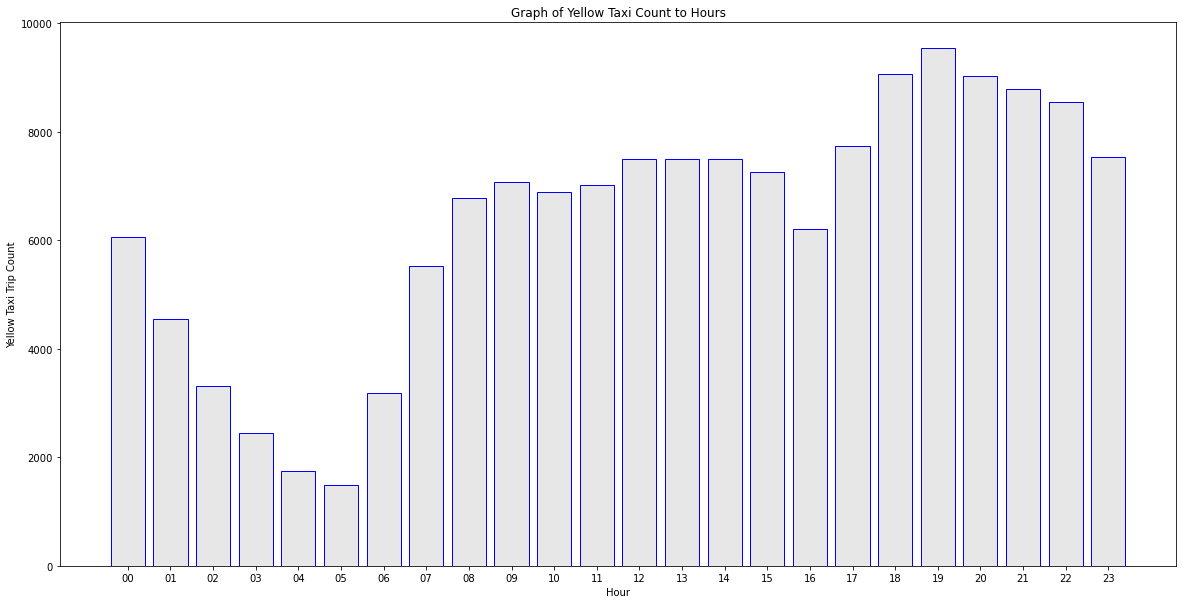

In [57]:
dataframe1 = pd.read_sql_query(text(QUERY_Q1),connection)

def plot_visual_1(dataframe):
    figure, axes = plt.subplots(figsize=(20, 10))
    plt.xlabel("Hour")
    plt.ylabel("Yellow Taxi Trip Count")
    axes.set_title("Graph of Yellow Taxi Count to Hours")
    plt.bar(dataframe["Hour_Taxi"], dataframe["COUNT(strftime ('%H',pickup_datetime))"], color=(0.1, 0.1, 0.1, 0.1),  edgecolor='blue');
    plt.show()

plot_visual_1(dataframe1)

### Q2

### Q5

2022-12-07 19:20:47,621 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("taxi_trips")
2022-12-07 19:20:47,622 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-12-07 19:20:47,623 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite~_%' ESCAPE '~' ORDER BY name
2022-12-07 19:20:47,623 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-12-07 19:20:47,624 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_temp_master WHERE type='table' AND name NOT LIKE 'sqlite~_%' ESCAPE '~' ORDER BY name
2022-12-07 19:20:47,624 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-12-07 19:20:47,625 INFO sqlalchemy.engine.Engine PRAGMA main.table_xinfo("taxi_trips")
2022-12-07 19:20:47,625 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-12-07 19:20:47,626 INFO sqlalchemy.engine.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = ? AND type in ('table', 'view')
2022-12-07 19:20:47,627 INFO sqlalc

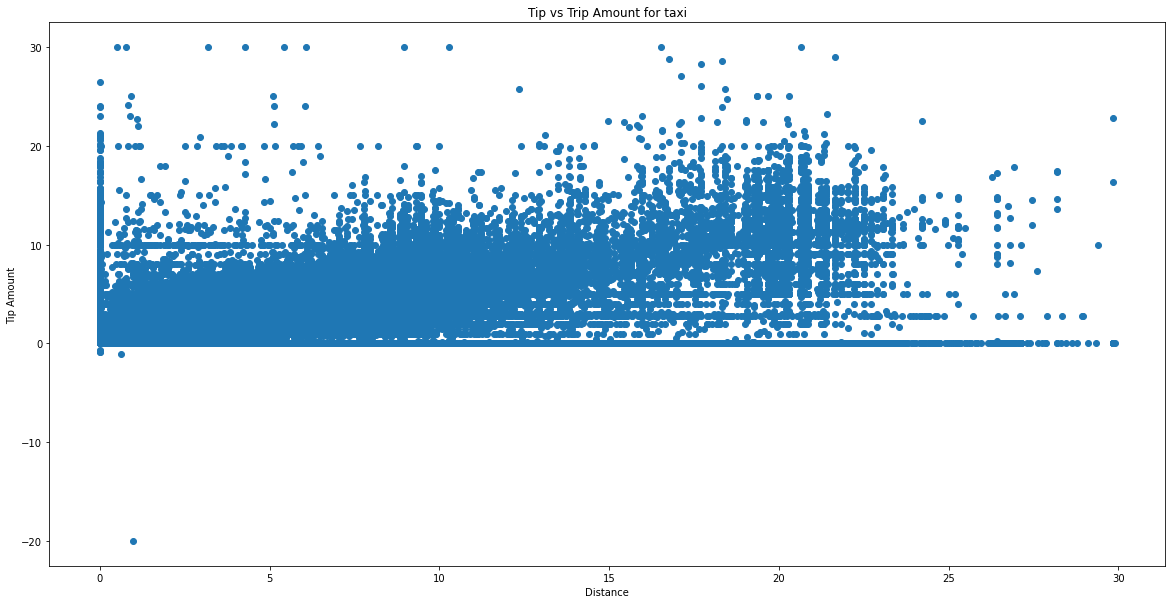

In [63]:
dataframe5=pd.read_sql("taxi_trips",connection)
dataframe5 = dataframe5.loc[dataframe5['Distance'] <= 30]
dataframe5 = dataframe5.loc[dataframe5['tip_amount'] <= 30]
def plot_visual_n(dataframe):
    figure, axes = plt.subplots(figsize=(20, 10))
    

    x=dataframe["Distance"]
    y=dataframe["tip_amount"]
    axes.set_title("Tip vs Trip Amount for taxi")
    plt.xlabel("Distance")
    plt.ylabel("Tip Amount")
    plt.scatter(x, y)
    plt.show()

plot_visual_n(dataframe5)

In [ ]:
# use a more descriptive name for your function
def plot_visual_n(dataframe):
    figure, axes = plt.subplots(figsize=(20, 10))
    
    values = "..."  # use the dataframe to pull out values needed to plot
    
    # you may want to use matplotlib to plot your visualizations;
    # there are also many other plot types (other 
    # than axes.plot) you can use
    axes.plot(values, "...")
    # there are other methods to use to label your axes, to style 
    # and set up axes labels, etc
    axes.set_title("Some Descriptive Title")
    
    plt.show()

In [ ]:
def get_data_for_visual_n():
    # Query SQL database for the data needed.
    # You can put the data queried into a pandas dataframe, if you wish
    raise NotImplemented()

In [ ]:
some_dataframe = get_data_for_visual_n()
plot_visual_n(some_dataframe)